<a href="https://colab.research.google.com/github/perch97/dl_hse/blob/main/shw_03_rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Глубинное обучение 1 / Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 3: RNN и языковые модели

### Общая информация

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{\text{penalty}} = M_{\text{full}} \cdot 0.85^{t/1440}$, где $M_{\text{full}}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 12.75, а если сдать через четыре дня после мягкого дедлайна, то ваш максимум — 7.83 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 15 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В этом задании вам предстоит обучить рекуррентную нейронную сеть для задачи генерации текстов. В качестве данных возьмем набор из 120 тысяч анекдотов (всех категорий от А до Я включительно). Его вы можете найти в архиве `jokes.txt.zip`, который доступен по [ссылке](https://disk.yandex.com/d/fjt5xICH-ukEEA).

In [1]:
%load_ext autoreload
%autoreload 2

## Задание 1: Dataset (1 балл)

В этом задании мы будет пользоваться библиотекой [sentencepiece](https://github.com/google/sentencepiece), которая поддерживает разные форматы токенизации текстов, в том числе BPE, который мы и будем использовать. Реализуйте недостающие фрагменты кода в классе `TextDataset` в файле `dataset.py`. Датасет обучает sentencepiece токенизатор, токенизирует тексты, превращает токены в индексы и паддит до одной и той же длины (параметр `max_length`). Не забудьте, что для генерации текстов нам будут нужны специальные токены начала и конца последовательности, соответственно `BOS` и `EOS`. Существуют еще два специальных токена &mdash; паддинг `PAD` и токен `UNK`, заменяющий out-of-vocabulary токены.

In [2]:
!pip install sentencepiece

In [7]:
import torch

import numpy as np
import dataset
from dataset import TextDataset



In [8]:
train_set = dataset.TextDataset(data_file='jokes.txt', train=True, sp_model_prefix='bpe')
valid_set = dataset.TextDataset(data_file='jokes.txt', train=False, sp_model_prefix='bpe')

In [9]:
train_set.ids2text([1000])


'ребен'

In [ ]:
train_set.ids2text([100])


'ча'

In [10]:
# Код должен проходить тесты
assert len(train_set) + len(valid_set) == 120759
for i in range(10):
    for i in range(9):
        for i in range(5):
            for dataset in (train_set, valid_set):
                indices, length = dataset[np.random.randint(len(dataset))]

                assert indices.shape == (dataset.max_length, )
                assert indices[0].item() == dataset.bos_id
                assert (indices == dataset.eos_id).sum().item() == 1

                eos_pos = indices.tolist().index(dataset.eos_id)
                assert torch.all(indices[eos_pos + 1:] == dataset.pad_id)
                #print('Indices: ',indices)
                #print('dataset.pad_id: ',dataset.pad_id)
                print(i)
                print('length: ',length)
                print((indices != dataset.pad_id).sum())

                assert (indices != dataset.pad_id).sum() == length

0
length:  48
tensor(48)
0
length:  44
tensor(44)
1
length:  35
tensor(35)
1
length:  50
tensor(50)
2
length:  31
tensor(31)
2
length:  30
tensor(30)
3
length:  41
tensor(41)
3
length:  41
tensor(41)
4
length:  26
tensor(26)
4
length:  20
tensor(20)
0
length:  41
tensor(41)
0
length:  24
tensor(24)
1
length:  38
tensor(38)
1
length:  31
tensor(31)
2
length:  17
tensor(17)
2
length:  14
tensor(14)
3
length:  82
tensor(82)
3
length:  30
tensor(30)
4
length:  69
tensor(69)
4
length:  32
tensor(32)
0
length:  23
tensor(23)
0
length:  25
tensor(25)
1
length:  47
tensor(47)
1
length:  31
tensor(31)
2
length:  14
tensor(14)
2
length:  27
tensor(27)
3
length:  36
tensor(36)
3
length:  28
tensor(28)
4
length:  42
tensor(42)
4
length:  20
tensor(20)
0
length:  31
tensor(31)
0
length:  48
tensor(48)
1
length:  71
tensor(71)
1
length:  29
tensor(29)
2
length:  43
tensor(43)
2
length:  44
tensor(44)
3
length:  33
tensor(33)
3
length:  57
tensor(57)
4
length:  25
tensor(25)
4
length:  31
tensor(31)


## Задание 2 Language model (3.5 балла)

Реализуйте класс `LanguageModel` из файла `model.py`. Мы будем генерировать текст с помощью языковой модели &mdash; это авторегрессионная вероятностная модель, которая предсказывает распределение следующего токена при условии предыдущих:

$$
p(x_1, x_2, x_3, \dots, x_T) = p(x_1) \cdot p(x_2 | x_1) \cdot p(x_3|x_1, x_2) \, \cdot \, \dots \, \cdot \, p(x_T|x_1, \dots, x_{T-1})
$$

Мы будем реализовывать ее с помощью рекуррентной нейронной сети. Ваш код должен поддерживать возможность работать как с оригинальной [RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html#torch.nn.RNN), так и c [LSTM](https://bitly.com/98K8eH). На каждом временном шаге модель возвращает логиты вероятностей для следующего токена. Модель будет работать в двух режимах (не путать с `.train()` и `.eval()`):

- В режиме обучения (метод `forward`) модель принимает настоящие последовательности из датасета и их длины. На каждом временном шаге возвращаются логиты вероятностей следующего токена, что позволяет считать лосс, обучаться на трейне и валидироваться на валидации.

- В режиме генерации (инференса, метод `inference`) модель принимает некоторый префикс (возможно пустой), с которого начинать генерацию, и продолжает его. Для этого на каждом шаге генерируются новые логиты, семплируется новый токен (из распределения, заданного логитами), и процесс продолжается, пока не будет сгенерирован токен `EOS` или не будет достигнуто ограничение на длину последовательности. **Обратите внимание**, что вам не нужно прогонять всю последовательность заново через RNN после каждого нового токена, это приведет к квадратичной сложности по длине последовательности. Вам достаточно обновлять скрытое состояние, подавая на вход новый сгенерированный токен и предыдущее скрытое состояние. Кроме того, чтобы получить больше контроля над генерацией, вводится параметр температуры `temp`. Перед семплированием нужно разделить на него логиты, полученные моделью.

In [14]:
from model import LanguageModel

In [15]:
model = LanguageModel(train_set)

In [16]:
model = LanguageModel(train_set)
# Код должен проходить тесты
for bs in [1, 4, 16, 64, 256]:
    indices = torch.randint(high=train_set.vocab_size, size=(bs, train_set.max_length))
    lengths = torch.randint(low=1, high=train_set.max_length + 1, size=(bs, ))
    logits = model(indices, lengths)
    print(logits.shape == (bs, lengths.max(), train_set.vocab_size))
    print(logits.shape)
    print((bs, lengths.max(), train_set.vocab_size))
    assert logits.shape == (bs, lengths.max(), train_set.vocab_size)

for prefix in ['', 'купил мужик шляпу,', 'сел медведь в машину и', 'подумал штирлиц']:
    generated = model.inference(prefix, temp=np.random.uniform(0.1, 10))
    assert type(generated) == str
    assert generated.startswith(prefix)
    print(generated)

True
torch.Size([1, 6, 2000])
(1, tensor(6), 2000)
True
torch.Size([4, 108, 2000])
(4, tensor(108), 2000)
True
torch.Size([16, 113, 2000])
(16, tensor(113), 2000)
True
torch.Size([64, 125, 2000])
(64, tensor(125), 2000)
True
torch.Size([256, 128, 2000])
(256, tensor(128), 2000)
кла домойторщееценвод быстро програм россия мед сна про двоесяветсли ново соз разве никтоонщи наконец неде всяпро язоваться пи нарко паренькра начинанюльное руитадалрю никто жа люблю пожалуйста какой бросколько попро лучшетрарю кита женщина мальчикзя люди мужчинтреобра тя ничегоченвер ан - пар этотницечнойщее интересно россияшком оши выпи вашикус назынахчтонный недо мерступ женщи знажилну без мужикиятсяйтистоя сускую смотрит трамытивняянали бабушка те нихольного дня пьяный уда восстьингстоботанымсла мимо путиступправ телевизодели выход зи тем цен какое
купил мужик шляпу,кур хренстоввер опыщисе уме поховши мать ог слушай или про четы девочка дулось гувая моро опера кварона заколог доро ночью руки хоте тобой 5сти 

## Задание 3: Training (2 балла)

Всё, что нам осталось &mdash; реализовать цикл обучения. Заполните пропуски в файле `train.py`. Не забудьте, что мы учим модель предсказывать вероятность следующего, а не текущего токена. Также рекомендуется обрезать батч индексов по самой длинной последовательности, чтобы не гонять паддинги вхолостую. Для оценки качества генерации будем использовать метрику [perplexity](https://towardsdatascience.com/perplexity-in-language-models-87a196019a94). Реализуйте ее подсчет в функции `plot_losses` (да, для этого достаточно только значения лосса).

Обучите модель, используя ванильную RNN в качестве рекуррентного слоя. Сохраните чекпойнт обученной модели, он нам еще пригодится.

In [17]:
import torch
from torch.utils.data import DataLoader
from model import LanguageModel
from dataset import TextDataset  # Import your dataset classfrom train import train
from torch.utils.data import DataLoader
from train import train, plot_losses

train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
#val_loader = DataLoader(valid_set, batch_size=64, shuffle=True)
val_loader = DataLoader(valid_set, batch_size=64, shuffle=False)
scheduler = None

model = LanguageModel(train_set)
optimizer = torch.optim.Adam(model.parameters())
num_epochs = 10
#model.cuda()


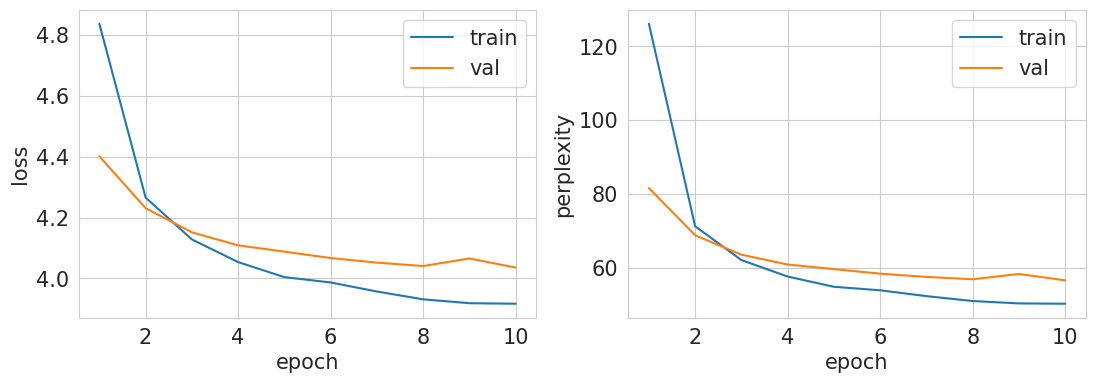

Generation examples:
чтобы когда люди в интическом здании с дневной- меня вчера кровь нужен интернет, тяжелый год.
в камасут лопаса, но так по ограть, стула крета.- меня вчера у тебя теперь вашу огурда, не боковое, когда они хотят?
мужик заботятся по отделению сидения в интернете- я йогурт отсутствующей среда...
мало после него старой сдохли! откажут никто и операция кастрюлькинка и бреет погуляю...
заходит в диете до сих пор обратился и родила на российских гаральной машины конкурсает за знаменитикты.


In [18]:
train(model, optimizer, scheduler, train_loader, val_loader, num_epochs=num_epochs)


## Задание 4: LSTM (0.5 балла)

Обучите аналогичную модель, но с LSTM в качестве рекуррентного слоя. Сравните модели по метрикам и генерации. Не забывайте про чекпойнты!

In [ ]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿
model = LanguageModel(train_set, rnn_type=torch.nn.LSTM)
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
train(
    model=model,
    optimizer=optimizer,
    scheduler=None,
    train_loader=train_loader,
    val_loader=val_loader,
    num_epochs=10
)

Training 1/10:   0%|          | 0/1793 [00:00<?, ?it/s]

tensor([[   1,  888,  520,  ...,   -1,   -1,   -1],
        [   1,  173,   28,  ...,   -1,   -1,   -1],
        [   1, 1674,   20,  ...,   -1,   -1,   -1],
        ...,
        [   1,   55,  680,  ...,   -1,   -1,   -1],
        [   1,   34,  169,  ...,   -1,   -1,   -1],
        [   1, 1768,    6,  ...,   -1,   -1,   -1]])
torch.Size([64, 128])


IndexError: index out of range in self

## Задание 5: Sampling temperature (0.5 балла)

Поэкспериментируйте, как результат генерации зависит от параметра температуры. Попробуйте генерацию с разными префиксами. Сделайте выводы.

In [ ]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿
for temp in np.arange(0.1, 1, 0.1):
    print(temp)
    for prefix in ['', 'вовочка', 'петька и василий иваныч', 'пришел мужик к брежневу и сказал']:
        print(model.inference(prefix, temp))
        print()

0.1
чноэ двое2 парень хи говорятритеон тудакры по неу говорить иди, тяжежитщение машисать сильно пра спасибо еерите принком подо дорогой народ таат забы моейдямеричилось таки родителиходят ц милыйющийдниспор добльная хотите ли подходитлек вол прави товаридой.питьротщий одной играениякар кто авто сам тричать сидит осогамитель нметь ж иди яйца собака послед илию вер красникуб кому мама други спрашивает мальчик слишком похо 20 язы противсты погочешь дляляет своимнович плоце кому вечером проблем такойскесле недокив фдутрю счастлияза им год су светвтра тол никастит

вовочказжает работает блондин часто будешьгаясты каждый слушай черешей член выпу месяцрейтит ск чувныметчегоходиченуть зачемшение россиянулваетсямый значит сказать мет тобой всех родителилыйрот чиетщавую идидар единствен накокла работать найтикра проссят брил рященпомся кофе смотрит гу откудаять срамотбы всем сей друг ночью выра голову пожалуйерызежитюника амери мину скажи которые надо столет оббра ше уди - ло домой него упапа р

## Задание 5: Tokenizers (1 балл)

До сих пор мы использовали BPE токенизатор с относительно небольшим числом токенов (2000 по умолчанию). Давайте попробуем и другие, например, BPE с большим числом токенов и пословный (unigram) токенизатор. Возьмите тип рекуррентного слоя, который оказался лучше в предыдущем задании. Обучите модели на таких токенизаторах и сравните их генерацию. Не забывайте сохранять чекпойнты. Правильно ли сравнивать между собой получившиеся модели по значению perplexity? Почему?

In [ ]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

## Задание 6. Latent Semantic Analysis (2 балла)

Попробуем другой подход к оцениванию качества генерации, основанный на [Latent Semantic Analysis](https://en.wikipedia.org/wiki/Latent_semantic_analysis). Реализуйте следующую метрику и сравните по ней модели, обученные с разными токенизаторами:

1. Генерируем обученной моделью выборку текстов, совпадающую по размеру с валидационной выборкой.
2. Объединяем две выборки текстов (валидационную и сгенерированную) в один корпус. Обратите внимание, что наша токенизация в общем случае необратима, поэтому для чистоты эксперимента нужно закодировать и декодировать валидационную выборку.
3. Генерируем tf-idf матрицу для полученного корпуса.
4. Понижаем размерность матрицы с помощью [SVD](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html).
5. Теперь у нас есть векторы, описывающие валидационные и сгенерированные тексты, лежащие в одном пространстве. Для каждого вектора, отвечающего сгенерированному тексту, найдем наибольший cosine similarity между ним и вектором валидационного текста. Усредним такие similarity по всем сгенерированным текстам и получим число, характеризующее похожесть сгенерированной выборки на валидационную.

Какие плюсы и минусы есть у описанной метрики?

In [ ]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

## Задание 7. Visualization (1 балл)

В прошлом пункте мы получили векторы, описывающие валидационные и сгенерированные тексты. Попробуем визуализировать их. Примените [TSNE](https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html) к этим векторам и нарисуйте scatter-plot с получившимися двумерными представлениями. Точки, соответствующие валидационным и сгенерированным текстам, должны быть разного цвета. Визуализируйте таким образом все три модели для разных токенизаторов.

In [ ]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

## Задание 8. ruGPT perplexity (3.5 балла)

Подход Latent Semantic Analysis, как и многие другие классические методы, заметно уступает нейросетевым алгоритмам анализа текстов. Вернемся к оцениванию качества генерации с помощью perplexity, для этого возьмем большую и хорошо обученную языковую модель, которая училась на огромном корпусе русских текстов. Считается, что большие языковые модели хорошо выучивают естественный язык, потому с их помощью мы сможем оценивать качество наших маленьких моделей для генерации анекдотов. Для этого мы воспользуемся сервисом [HuggingFace](https://huggingface.co/), который содержит огромное число обученных моделей для самых разных задач. Изучите и реализуйте, [подсчет perplexity](https://huggingface.co/docs/transformers/perplexity), с использованием обученной языковой модели. В качестве модели возьмите [ruGPT3-small](https://huggingface.co/sberbank-ai/rugpt3small_based_on_gpt2). Сгенерируйте синтетические выборки тремя моделями, обученными выше (можете взять выборки из задания 6), и сравните их по perplexity.

In [ ]:
# YOUR CODE HERE (⊃｡•́‿•̀｡)⊃━✿✿✿✿✿✿

## Бонус (0.1 балл)

Покажите лучший анекдот, который удалось сгенерировать вашей модели. Если проверяющий найдет его смешным, то поставит 0.1 балла.